In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Dataset directory
dataset_dir = '/Users/mandylee/Documents/AI/GenAIProject/ArtiFace'

# List all image paths and their corresponding labels
image_paths = []
labels = []

# Supported image extensions
valid_image_extensions = ['.jpg', '.jpeg', '.png']

# Step 1: Loop through the 'Fake' and 'Real' folders
for class_name in ['Fake', 'Real']:
    class_dir = os.path.join(dataset_dir, class_name)

    # Loop through the folders in 'Fake' and 'Real'
    for subdir in os.listdir(class_dir):
        subdir_path = os.path.join(class_dir, subdir)

        # Process each subdirectory (like 'Stable_Diffusion', 'StarGAN', etc.)
        if os.path.isdir(subdir_path):
            for img_name in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img_name)

                # Check if the file is a valid image
                if any(img_path.endswith(ext) for ext in valid_image_extensions):
                    image_paths.append(img_path)
                    labels.append(1 if class_name == 'Fake' else 0)  # Fake = 1, Real = 0

# Step 2: Split the dataset into training and testing datasets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Step 3: Check the distribution of classes in the datasets
print("Training set class distribution:", np.unique(train_labels, return_counts=True))
print("Testing set class distribution:", np.unique(test_labels, return_counts=True))

# Optionally, check the number of images
print("Total images:", len(image_paths))
print("Training images:", len(train_paths))
print("Testing images:", len(test_paths))


Training set class distribution: (array([0, 1]), array([42694, 42626]))
Testing set class distribution: (array([0, 1]), array([10674, 10656]))
Total images: 106650
Training images: 85320
Testing images: 21330


In [3]:
# Step 2: Use ImageDataGenerator with Custom Splits
# Create a DataFrame for training and validation paths and labels
train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_paths, 'class': test_labels})

# Convert labels to string as required by flow_from_dataframe
train_df['class'] = train_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

# Data augmentation and preprocessing for MobileNetV2
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    channel_shift_range=0.1,  # Small color variations
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for training and validation
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Load MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 30 layers for fine-tuning
# for layer in base_model.layers[-30:]:
#     layer.trainable = True

tensorflow.keras.regularizers.L2(l2=0.01)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)

# First Dense layer
x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second Dense layer
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Output layer
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("mobilenet_best_model.keras", save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    callbacks=callbacks,
    verbose=1
)

# Save the trained model
model.save("mobilenet_final_model2.keras")

import pandas as pd

Found 85320 validated image filenames belonging to 2 classes.
Found 21330 validated image filenames belonging to 2 classes.


2025-03-16 21:31:45.118057: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-16 21:31:45.118077: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-16 21:31:45.118079: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1742131905.118089 1153274 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742131905.118103 1153274 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,431,041 (9.27 MB)

 Trainable params: 172,673 (674.50 KB)

 Non-trainable params: 2,258,368 (8.61 MB)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-03-16 21:31:47.119502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2667/2667 ━━━━━━━━━━━━━━━━━━━━ 680s 254ms/step - Precision: 0.6380 - Recall: 0.6374 - accuracy: 0.6371 - loss: 2.1121 - val_Precision: 0.7404 - val_Recall: 0.8550 - val_accuracy: 0.7778 - val_loss: 0.7800
Epoch 2/10
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 905s 339ms/step - Precision: 0.7273 - Recall: 0.7196 - accuracy: 0.7273 - loss: 0.7802 - val_Precision: 0.7222 - val_Recall: 0.9021 - val_accuracy: 0.7778 - val_loss: 0.5610
Epoch 3/10
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 1031s 387ms/step - Precision: 0.7440 - Recall: 0.7380 - accuracy: 0.7427 - loss: 0.5993 - val_Precision: 0.7587 - val_Recall: 0.8612 - val_accuracy: 0.7939 - val_loss: 0.4881
Epoch 4/10
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 998s 374ms/step - Precision: 0.7588 - Recall: 0.7556 - accuracy: 0.7584 - loss: 0.5417 - val_Precision: 0.7642 - val_Recall: 0.8526 - val_accuracy: 0.7949 - val_loss: 0.4727
Epoch 5/10
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 992s 372ms/step - Precision: 0.7609 - Recall: 0.7561 - accuracy: 0.7590 - loss: 0.5302 - val_Precision: 

Final results saved successfully: {'Final Train Accuracy': 0.7581223845481873, 'Final Val Accuracy': 0.7782934904098511, 'Final Train Loss': 0.5284284949302673, 'Final Val Loss': 0.4948660731315613, 'Final Train Precision': 0.7620171308517456, 'Final Val Precision': 0.7218354940414429, 'Final Train Recall': 0.7501290440559387, 'Final Val Recall': 0.9049361944198608}


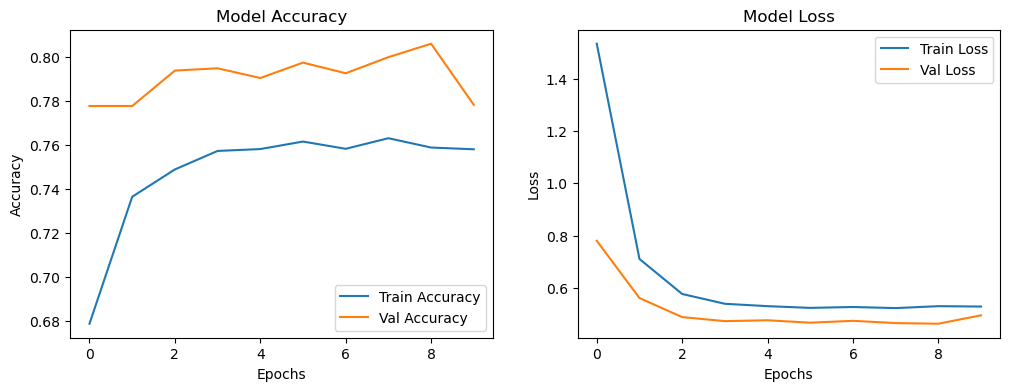

667/667 ━━━━━━━━━━━━━━━━━━━━ 3054s 5s/step


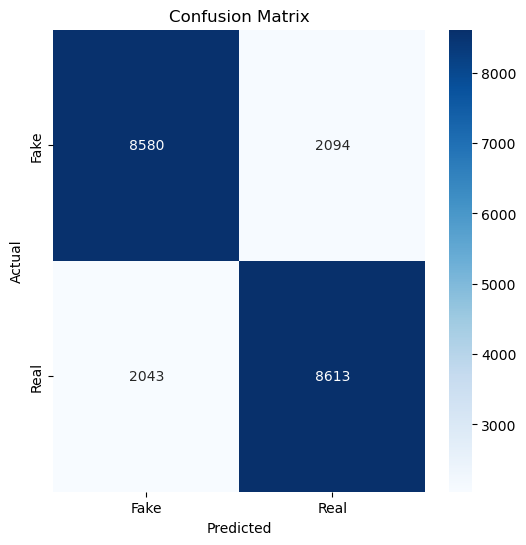

In [4]:
import pandas as pd

# Convert history to DataFrame and save as CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_results.csv', index=False)

import matplotlib.pyplot as plt

# Extract final epoch values
final_results = {
    "Final Train Accuracy": history.history['accuracy'][-1],
    "Final Val Accuracy": history.history['val_accuracy'][-1],
    "Final Train Loss": history.history['loss'][-1],
    "Final Val Loss": history.history['val_loss'][-1],
    "Final Train Precision": history.history['Precision'][-1],
    "Final Val Precision": history.history['val_Precision'][-1],
    "Final Train Recall": history.history['Recall'][-1],
    "Final Val Recall": history.history['val_Recall'][-1]
}

# Save final results to a text file
with open("final_results.txt", "w") as f:
    for key, value in final_results.items():
        f.write(f"{key}: {value:.4f}\n")

print("Final results saved successfully:", final_results)

# Create a figure for the plots
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.savefig('accuracy_plot.png')  # Save accuracy plot

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.savefig('loss_plot.png')  # Save loss plot

plt.show()

# Save model architecture
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# To load the model later
# from tensorflow.keras.models import model_from_json

# with open("model_architecture.json", "r") as json_file:
#     loaded_model_json = json_file.read()

# model = model_from_json(loaded_model_json)

model.save_weights("model.weights.h5")

hyperparams = {
    "Batch Size": 32,
    "Learning Rate": 0.0001,
    "Epochs": 15,
    "Image Size": (224, 224),
    "Optimizer": "Adam"
}

# Save to a JSON file
import json
with open("hyperparameters.json", "w") as f:
    json.dump(hyperparams, f, indent=4)

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Get predictions on the test set
model.trainable = False
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels
y_true = test_generator.classes  # True labels

# Save Classification Report
report = classification_report(y_true, y_pred_classes, output_dict=True)
pd.DataFrame(report).transpose().to_csv("classification_report.csv")

# Save Confusion Matrix as PNG
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()